# LeNet on MNIST using PyTorch

This notebook creates a LeNet architecture in PyTorch and trains it on the Fashion MNIST image dataset. I am doing this to learn PyTorch.

Steps:

- Create a Dataset
- Create a DataLoader
- Define a Network
- Run a training loop
- Plot training loss
- Classify the test dataset
- Calculate test accuracy

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
import numpy as np
import matplotlib.pyplot as plt

user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/fashion/'

os.makedirs(PATH, exist_ok=True)

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
train_ds = FashionMNIST(root=PATH, train=True, download=True, transform=transform)
test_ds = FashionMNIST(root=PATH, train=False, download=True, transform=transform)
label_names = [
    'top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'ankle boot',
]


In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

## Define Network

In [16]:
import torch.nn as nn

CONV_1 = 32
CONV_2 = 64
HIDDEN_1 = 120
HIDDEN_2 = 60
OUT = 10

class Flatten(nn.Module):
    def forward(self, x):
        return x.flatten(start_dim=1)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.network = nn.Sequential(
            # 28x28 grayscale input
            nn.Conv2d(in_channels=1, out_channels=CONV_1, kernel_size=5),
            # 24x24
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 12x12
            nn.Conv2d(in_channels=CONV_1, out_channels=CONV_2, kernel_size=5),
            # 8x8
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 4x4
            Flatten(),
            nn.Linear(CONV_2*4*4, HIDDEN_1),
            nn.ReLU(),
            # TODO - try batch normalization?
            nn.Dropout(0.3),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU(),
            # TODO - try batch normalization?
            nn.Linear(HIDDEN_2, OUT),
            nn.LogSoftmax(dim=1),
        )
        
        
    def forward(self, input_t):
        return self.network(input_t)


## Training Loop

In [32]:
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim

NUM_EPOCHS = 20
LEARNING_RATE = 0.001
ADAM_BETAS = (0.9, 0.999)
WEIGHT_DECAY = 1e-6

net = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS)


def apply_weight_decay(optimizer):
    for group in optimizer.param_groups:
        for param in group['params']:
            param.data = param.data.add(-WEIGHT_DECAY * group['lr'], param.data)

loss_history = []
loss_avg = 0
loss_beta = 0.8
for epoch in range(NUM_EPOCHS):    
    progress = tqdm(
        iterable=iter(train_dl),
        leave=False,
        desc=f'epoch {epoch + 1} / {NUM_EPOCHS}',
        total=len(train_dl),
        miniters=0
    )
    for images, labels in progress:
        optimizer.zero_grad()
        outputs = net(images.float().cuda())
        loss = criterion(outputs.cpu(), labels)
        loss.backward()
        loss_amount = loss.data.item()
        loss_avg = loss_beta * loss_avg + (1 - loss_beta) * loss_amount
        progress.set_postfix(loss=loss_avg, refresh=False)
        loss_history.append(loss_amount)
        apply_weight_decay(optimizer)
        optimizer.step()            
    
    progress.close()
    print(f'epoch {epoch + 1} / {NUM_EPOCHS}, loss: {loss_avg:0.4f}')

epoch 1 / 20, loss: 0.4053


epoch 2 / 20, loss: 0.3280


epoch 3 / 20, loss: 0.2814


epoch 4 / 20, loss: 0.2787


epoch 5 / 20, loss: 0.2307


epoch 6 / 20, loss: 0.2267


epoch 7 / 20, loss: 0.2231


epoch 8 / 20, loss: 0.2055


epoch 9 / 20, loss: 0.1758


epoch 10 / 20, loss: 0.1821


epoch 11 / 20, loss: 0.1580


epoch 12 / 20, loss: 0.1495


epoch 13 / 20, loss: 0.1389


epoch 14 / 20, loss: 0.1650


epoch 15 / 20, loss: 0.1477


epoch 16 / 20, loss: 0.1260


epoch 17 / 20, loss: 0.1215


epoch 18 / 20, loss: 0.1045


epoch 19 / 20, loss: 0.0751


epoch 20 / 20, loss: 0.1087


## Plot Training Loss

Text(0, 0.5, 'Loss')

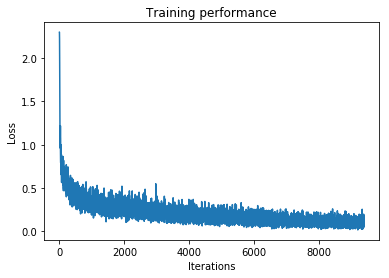

In [33]:
fig, ax = plt.subplots()
ax.plot(loss_history)
ax.set_title('Training performance')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

## Classify Test Dataset

In [34]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True, num_workers=7)
images, labels = next(iter(test_dl))
outputs = net(images.float().cuda())
loss = criterion(outputs.cpu(), labels)
print(f'Test loss of {loss.data.item():.2f}')

Test loss of 0.35


In [35]:
predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
images, labels = images.cpu().numpy(), labels.cpu().numpy()

In [36]:
accuracy = 100.0 * (labels == predicted_labels).sum().item() / len(labels)
print(f'Accuracy on test set is {accuracy}%')

Accuracy on test set is 90.67%


## Plot the first 25 images in the dataset.


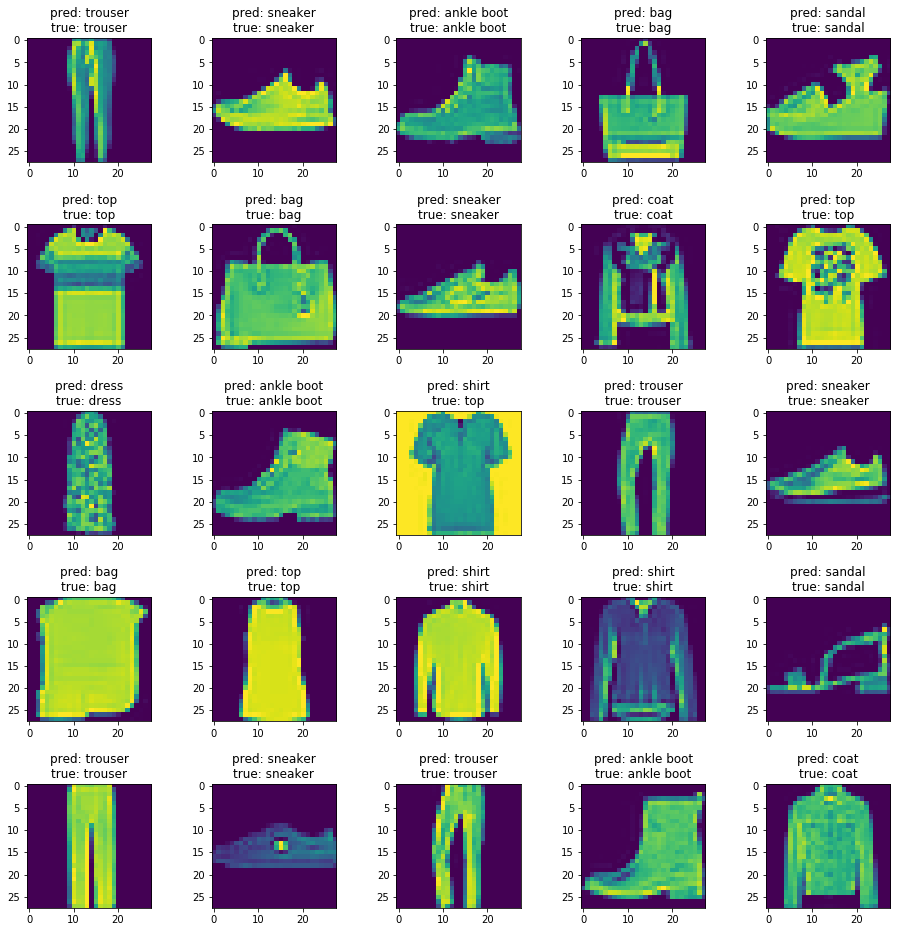

In [37]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16,))

idx = 0

for axarr in axes:
    for ax in axarr:    
        img = images[idx][0]
        pred = predicted_labels[idx]
        true = labels[idx]
        if int(pred) != int(true):
            img = 255 - img

        ax.imshow(img)
        ax.set_title(f'pred: {label_names[pred]}\ntrue: {label_names[true]}')
        idx += 1
        
fig.subplots_adjust(hspace=0.5)

## Plot at most 25 misclassified images.


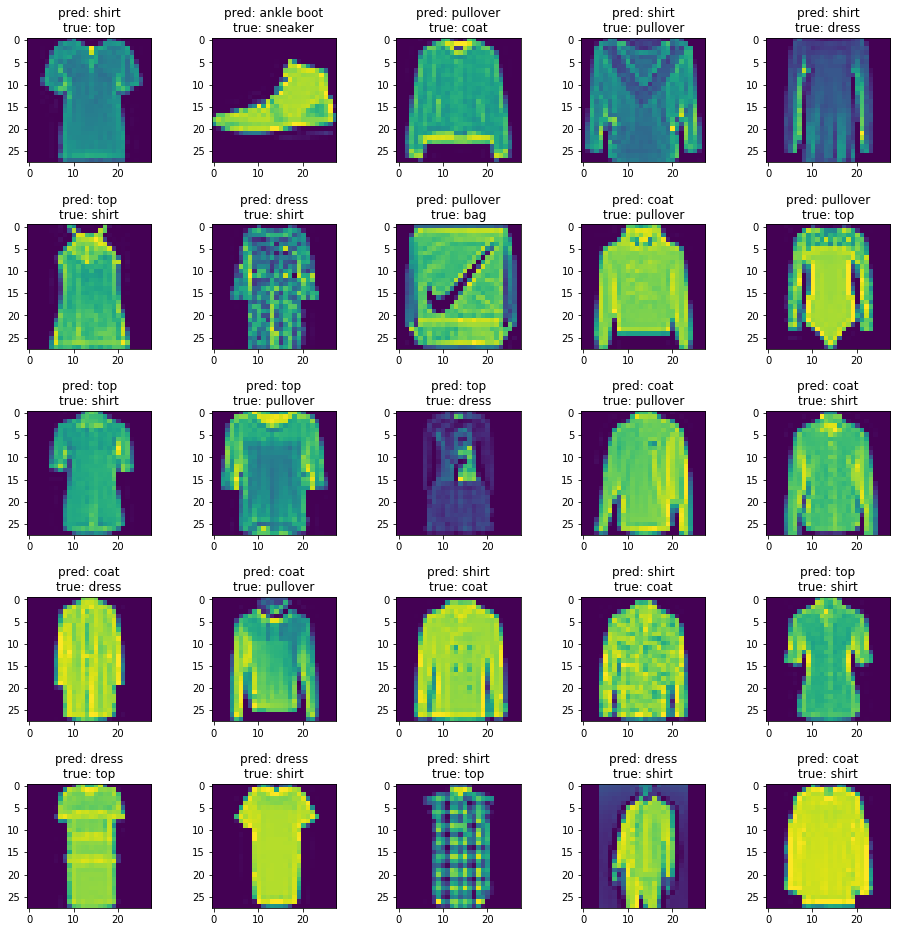

In [38]:
rows, cols = 5, 5
mask = labels != predicted_labels
wrong_images = images[mask][:rows * cols]
wrong_labels = labels[mask][:rows * cols]
wrong_pred = predicted_labels[mask][:rows * cols]

idx = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 16,))
for axarr in axes:
    for ax in axarr:    
        img = wrong_images[idx]
        pred = wrong_pred[idx]
        true = wrong_labels[idx]
        idx += 1
        ax.imshow(img[0])
        ax.set_title(f'pred: {label_names[pred]}\ntrue: {label_names[true]}')
        
fig.subplots_adjust(hspace=0.5)